In [460]:
import numpy as np
import pickle
import sys
sys.path.append('/nmnt/media/home/anvar/conferences_code/NET2017/utils')
from utils import squeeze_matrix, l2, binar, l1
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('data_BNU_pickled', 'rb') as f:
    data = pickle.load(f)
    
hierarchy = np.loadtxt(
    '/nmnt/media/home/anvar/conferences_code/NET2017/text_files/Lausanne_hierarchy.txt',
    dtype='int')-1

h = {}
h['33'], h['60'], h['125'], h['250'], h['500'] = hierarchy[0], \
hierarchy[1], hierarchy[2], hierarchy[3], hierarchy[4]

In [19]:
format_hierarchy = {
    '500_250':None,
    '500_125':None,
    '500_60':None,
    '500_33':None,
    '250_125':None,
    '250_60':None,
    '250_33':None,
    '125_60':None,
    '125_33':None,
    '60_33':None,
}

format_hierarchy['500_250'] = dict(zip(h['500'], h['250']))
format_hierarchy['500_125'] = dict(zip(h['500'], h['125']))
format_hierarchy['500_60'] = dict(zip(h['500'], h['60']))
format_hierarchy['500_33'] = dict(zip(h['500'], h['33']))

format_hierarchy['250_125'] = dict(zip(h['250'], h['125']))
format_hierarchy['250_60'] = dict(zip(h['250'], h['60']))
format_hierarchy['250_33'] = dict(zip(h['250'], h['33']))

format_hierarchy['125_60'] = dict(zip(h['125'], h['60']))
format_hierarchy['125_33'] = dict(zip(h['125'], h['33']))

format_hierarchy['60_33'] = dict(zip(h['60'], h['33']))

In [181]:
def squeeze_matrix(matrix, scale, input_size, output_size, normed=False):
    
    transform = np.zeros((input_size, output_size))
    for key,value in scale.items():
        transform[key, value] = 1
        
    squeezed = transform.T.dot(matrix.dot(transform))
    
    if normed is True:
        vertices_frequency = np.unique(np.array(list(scale.values())),
                               return_counts=True)[1][:, np.newaxis]
        normed_mask = vertices_frequency.dot(
                      vertices_frequency.T)
        squeezed /= normed_mask
        
    np.fill_diagonal(squeezed, 0)
    
    return squeezed

def create_squeeze(data, algorithm, hierarchy, ):
    '''
    INPUT:    
    data - dictionary (with keys: algorithm_33,60,125,250,500)
    algorithm - truncated key of data(ex. proba_csa)
    hierarchy - lausanne hierarchy dictionary (with keys: 33,60,125,250,500)
    
    OUTPUT:
    squeezed_data - dictionary with 10 keys: 
    500_250, 500_125, 500_60, 500_33, 250_125, 250_60, 250_33, 125_60, 125_33, 60_33 
    '''
    
    squeezed_data = {'500_250':None,'500_125':None,'500_60':None,'500_33':None,'250_125':None,
                     '250_60':None,'250_33':None,'125_60':None,'125_33':None,'60_33':None,}
    
    scale_dict = {'500': 1000,'250': 448,'125': 219,'60': 114,'33': 68}
    n_observations = 98
    
    for key in squeezed_data.keys():
        
        original_scale, squeezed_scale = key.split('_')
        data_key = algorithm + '_' + original_scale
        
        temp_data = data[data_key]
        temp_squeezed = np.zeros((n_observations,
                                  scale_dict[squeezed_scale],
                                  scale_dict[squeezed_scale]))
        
        for idx, matrix in enumerate(temp_data):
            temp_squeezed[idx] = squeeze_matrix(matrix, hierarchy[key],
                                                scale_dict[original_scale],
                                                scale_dict[squeezed_scale])
            
        squeezed_data[key] = temp_squeezed
        
    return squeezed_data

# Some experiments with the weighted matrices

In [465]:
def squeeze_matrix(matrix, scale, input_size, output_size, normed=False, factor=1):
    
    transform = np.zeros((input_size, output_size))
    for key,value in scale.items():
        transform[key, value] = 1
        
    squeezed = transform.T.dot(matrix.dot(transform))
    
    if normed is True:
        vertices_frequency = np.unique(np.array(list(scale.values())),
                               return_counts=True)[1][:, np.newaxis]
        normed_mask = vertices_frequency.dot(
                      vertices_frequency.T)
        #squeezed /= normed_mask
        #squeezed /= (np.sqrt(normed_mask))
        #squeezed /= (np.sqrt(normed_mask)/2)
        
        #squeezed /= (normed_mask*factor) 
#         if factor is not None:
#             squeezed /= (np.power(normed_mask,0.5)) 
        squeezed /= np.power(normed_mask, factor)
        
    np.fill_diagonal(squeezed, 0)
    
    return squeezed

In [338]:
idx = 1
pipe1 = 'deter_csa_125'
pipe2 = 'deter_csa_33'

scale_dict = {'500': 1000,'250': 448,'125': 219,'60': 114,'33': 68}
h_idx = '_'.join([pipe1.split('_')[2], pipe2.split('_')[2]])
scale_from = scale_dict[pipe1.split('_')[2]]
scale_to = scale_dict[pipe2.split('_')[2]]

temp_normed = squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx], scale_from, scale_to, normed=True)
temp =  squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx], scale_from, scale_to, normed=False)
original = data[pipe2][idx]

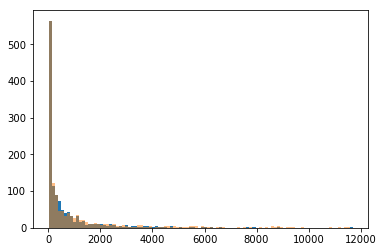

In [339]:
_,bins = np.histogram(squareform(original)[squareform(original)>10], bins=100)
plt.hist(squareform(original)[squareform(original)>10], bins=bins);
plt.hist(squareform(temp)[squareform(temp)>10], bins=bins, alpha=0.5);

In [378]:
pipe1 = 'deter_csa_250'
pipe2 = 'deter_csa_125'

scale_dict = {'500': 1000,'250': 448,'125': 219,'60': 114,'33': 68}
h_idx = '_'.join([pipe1.split('_')[2], pipe2.split('_')[2]])
scale_from = scale_dict[pipe1.split('_')[2]]
scale_to = scale_dict[pipe2.split('_')[2]]

diff_original_temp = []
diff_original_temp_normed = []
diff_original_temp_normed_sq = []
diff_original_temp_normed_cube = []

for idx in range(98):
    
    original = data[pipe2][idx]
    temp =  squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx], scale_from, scale_to, normed=False)
    temp_normed = squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx],
                                 scale_from, scale_to, normed=True, factor=1)
    temp_normed_sq = squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx],
                                    scale_from, scale_to, normed=True, factor=1/2)
    
    temp_normed_cube = squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx],
                                    scale_from, scale_to, normed=True, factor=1/3)
    
    diff_original_temp.append(l2(original, temp))
    diff_original_temp_normed.append(l2(original, temp_normed))
    diff_original_temp_normed_sq.append(l2(original, temp_normed_sq))
    diff_original_temp_normed_cube.append(l2(original, temp_normed_cube))

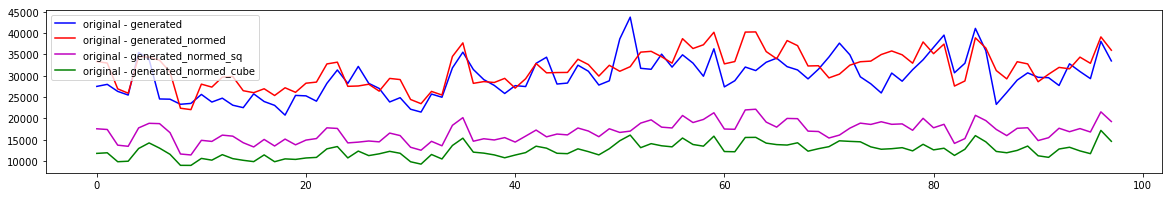

In [379]:
plt.figure(figsize=(20,3))
plt.plot(list(range(98)), diff_original_temp, c='b', label='original - generated')
plt.plot(list(range(98)), diff_original_temp_normed, c='r', label='original - generated_normed')
plt.plot(list(range(98)), diff_original_temp_normed_sq, c='m', label='original - generated_normed_sq')
plt.plot(list(range(98)), diff_original_temp_normed_cube, c='g', label='original - generated_normed_cube')
plt.legend()

In [382]:
pipe1 = 'deter_dti_500'
pipe2 = 'deter_dti_60'

scale_dict = {'500': 1000,'250': 448,'125': 219,'60': 114,'33': 68}
h_idx = '_'.join([pipe1.split('_')[2], pipe2.split('_')[2]])
scale_from = scale_dict[pipe1.split('_')[2]]
scale_to = scale_dict[pipe2.split('_')[2]]

diff_original_temp = []
diff_original_temp_normed = []
diff_original_temp_normed_sq = []
diff_original_temp_normed_cube = []

for idx in range(98):
    
    original = data[pipe2][idx]
    temp =  squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx], scale_from, scale_to, normed=False)
    temp_normed = squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx],
                                 scale_from, scale_to, normed=True, factor=1)
    temp_normed_sq = squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx],
                                    scale_from, scale_to, normed=True, factor=1/2)
    
    temp_normed_cube = squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx],
                                    scale_from, scale_to, normed=True, factor=1/3)
    
    diff_original_temp.append(l2(original, temp))
    diff_original_temp_normed.append(l2(original, temp_normed))
    diff_original_temp_normed_sq.append(l2(original, temp_normed_sq))
    diff_original_temp_normed_cube.append(l2(original, temp_normed_cube))

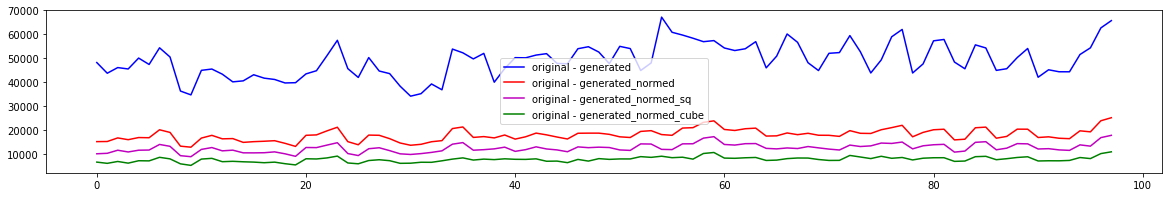

In [383]:
plt.figure(figsize=(20,3))
plt.plot(list(range(98)), diff_original_temp, c='b', label='original - generated')
plt.plot(list(range(98)), diff_original_temp_normed, c='r', label='original - generated_normed')
plt.plot(list(range(98)), diff_original_temp_normed_sq, c='m', label='original - generated_normed_sq')
plt.plot(list(range(98)), diff_original_temp_normed_cube, c='g', label='original - generated_normed_cube')
plt.legend()

# Exploratory with binarized matrices

In [466]:
def scale_comparison(data, hierarchy, pipe1, pipe2):
    
    scale_dict = {'500': 1000,'250': 448,'125': 219,'60': 114,'33': 68}
    h_idx = '_'.join([pipe1.split('_')[2], pipe2.split('_')[2]])
    scale_from = scale_dict[pipe1.split('_')[2]]
    scale_to = scale_dict[pipe2.split('_')[2]]

    diff_original_temp = []


    for idx in range(98):

        original = binar(data[pipe2][idx])
        temp =  binar(squeeze_matrix(data[pipe1][idx], format_hierarchy[h_idx],
                                     scale_from, scale_to, normed=False))

        diff_original_temp.append(l1(original, temp))
    
    return np.array(diff_original_temp)[:, np.newaxis]

In [467]:
algorithm = 'proba_csd'

In [469]:
pipe1 = '_'.join([algorithm, '500'])
pipe2 = '_'.join([algorithm, '250'])
pipe3 = '_'.join([algorithm, '125'])
pipe4 ='_'.join([algorithm, '60'])
pipe5 = '_'.join([algorithm, '33'])

diff_500_250 = scale_comparison(data, format_hierarchy, pipe1, pipe2)
diff_500_125 = scale_comparison(data, format_hierarchy, pipe1, pipe3)
diff_500_60 = scale_comparison(data, format_hierarchy, pipe1, pipe4)
diff_500_33 = scale_comparison(data, format_hierarchy, pipe1, pipe5)

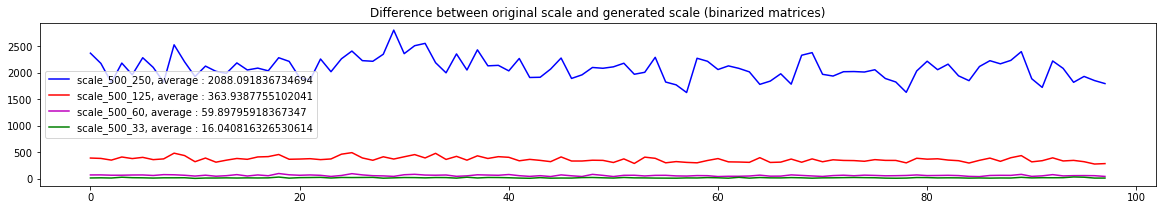

In [470]:
plt.figure(figsize=(20,3))
plt.plot(list(range(98)), diff_500_250, c='b', label='scale_500_250, average : {}'.format(np.mean(diff_500_250)))
plt.plot(list(range(98)), diff_500_125, c='r', label='scale_500_125, average : {}'.format(np.mean(diff_500_125)))
plt.plot(list(range(98)), diff_500_60, c='m', label='scale_500_60, average : {}'.format(np.mean(diff_500_60)))
plt.plot(list(range(98)), diff_500_33, c='g', label='scale_500_33, average : {}'.format(np.mean(diff_500_33)))
plt.legend()
plt.title('Difference between original scale and generated scale (binarized matrices)');

In [471]:
pipe1 = '_'.join([algorithm, '250'])
pipe3 = '_'.join([algorithm, '125'])
pipe4 = '_'.join([algorithm, '60'])
pipe5 = '_'.join([algorithm, '33'])


diff_250_125 = scale_comparison(data, format_hierarchy, pipe1, pipe3)
diff_250_60 = scale_comparison(data, format_hierarchy, pipe1, pipe4)
diff_250_33 = scale_comparison(data, format_hierarchy, pipe1, pipe5)

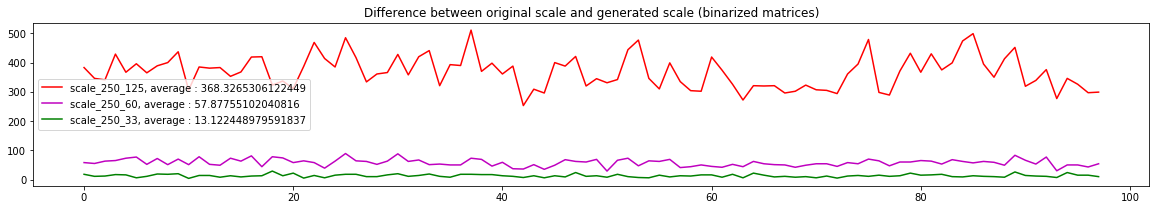

In [472]:
plt.figure(figsize=(20,3))

plt.plot(list(range(98)), diff_250_125, c='r', label='scale_250_125, average : {}'.format(np.mean(diff_250_125)))
plt.plot(list(range(98)), diff_250_60, c='m', label='scale_250_60, average : {}'.format(np.mean(diff_250_60)))
plt.plot(list(range(98)), diff_250_33, c='g', label='scale_250_33, average : {}'.format(np.mean(diff_250_33)))
plt.legend()
plt.title('Difference between original scale and generated scale (binarized matrices)');

In [473]:
pipe1 = '_'.join([algorithm, '125'])
pipe4 = '_'.join([algorithm, '60'])
pipe5 = '_'.join([algorithm, '33'])
diff_125_60 = scale_comparison(data, format_hierarchy, pipe1, pipe4)
diff_125_33 = scale_comparison(data, format_hierarchy, pipe1, pipe5)

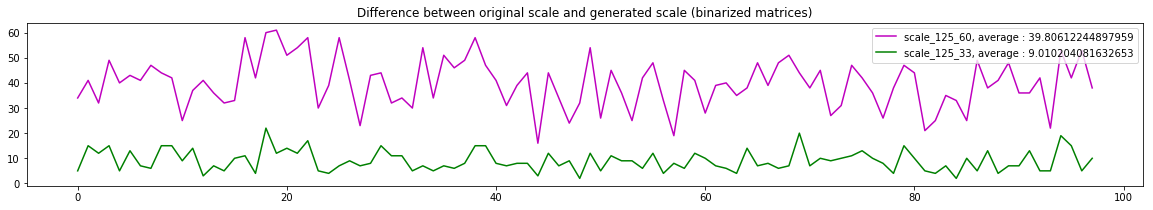

In [474]:
plt.figure(figsize=(20,3))

plt.plot(list(range(98)), diff_125_60, c='m', label='scale_125_60, average : {}'.format(np.mean(diff_125_60)))
plt.plot(list(range(98)), diff_125_33, c='g', label='scale_125_33, average : {}'.format(np.mean(diff_125_33)))
plt.legend()
plt.title('Difference between original scale and generated scale (binarized matrices)');

In [475]:
pipe1 = '_'.join([algorithm, '60'])
pipe5 = '_'.join([algorithm, '33'])
diff_60_33 = scale_comparison(data, format_hierarchy, pipe1, pipe5)

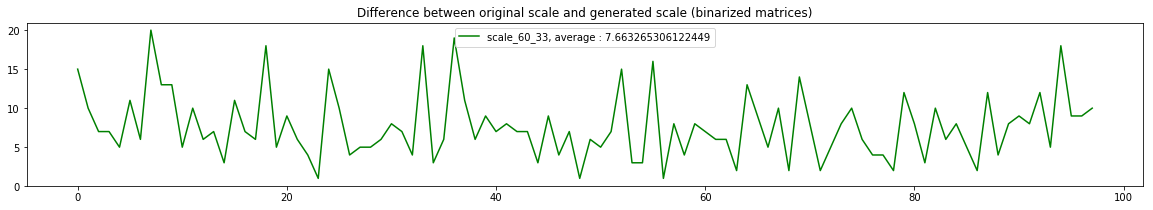

In [476]:
plt.figure(figsize=(20,3))

plt.plot(list(range(98)), diff_60_33, c='g', label='scale_60_33, average : {}'.format(np.mean(diff_60_33)))
plt.legend()
plt.title('Difference between original scale and generated scale (binarized matrices)');

In [477]:
all_diffs = np.concatenate([diff_500_250, diff_500_125, diff_500_60, diff_500_33, 
diff_250_125, diff_250_60, diff_250_33, diff_125_60,
diff_125_33, diff_60_33], axis=1)

In [480]:
idx=0
squareform(np.round(all_diffs[idx, :], 1))

array([[    0.,  2369.,   389.,    70.,    13.],
       [ 2369.,     0.,   383.,    58.,    18.],
       [  389.,   383.,     0.,    34.,     5.],
       [   70.,    58.,    34.,     0.,    15.],
       [   13.,    18.,     5.,    15.,     0.]])

In [481]:
idx=1
squareform(np.round(all_diffs[idx, :], 1))

array([[    0.,  2176.,   382.,    71.,    16.],
       [ 2176.,     0.,   346.,    55.,    11.],
       [  382.,   346.,     0.,    41.,    15.],
       [   71.,    55.,    41.,     0.,    10.],
       [   16.,    11.,    15.,    10.,     0.]])

In [483]:
squareform(np.round(all_diffs.mean(axis=0), 1))

array([[    0. ,  2088.1,   363.9,    59.9,    16. ],
       [ 2088.1,     0. ,   368.3,    57.9,    13.1],
       [  363.9,   368.3,     0. ,    39.8,     9. ],
       [   59.9,    57.9,    39.8,     0. ,     7.7],
       [   16. ,    13.1,     9. ,     7.7,     0. ]])